In [1]:
!pip install qiskit_aer
!pip install qiskit_ibm_runtime
import numpy as np
from qiskit import *
from qiskit_aer import *
from qiskit.visualization import *
from qiskit_ibm_runtime import *
import matplotlib.pyplot as plt

QiskitRuntimeService.save_account(channel="ibm_quantum", token="2fa48b871da110f709816b52051208c4e6665bd717a4dddf7192d8df4fa14f17dba0bc77d1e1fede36999b62c5a55172c748052a2eeaf9358308979abab7ea36", overwrite=True, set_as_default=True)
service = QiskitRuntimeService()

backend = service.backend('ibm_sherbrooke')

backend_properties = backend.properties()

# Extract useful noise data (T1, T2, gate errors, readout errors)
qubit_index = 0  # example for qubit 0
t1 = backend_properties.t1(qubit_index)  # T1 time for qubit 0
t2 = backend_properties.t2(qubit_index)  # T2 time for qubit 0
readout_error = backend_properties.readout_error(qubit_index)  # Readout error for qubit 0
ecr = backend.target["ecr"][(1,0)]  # CNOT gate error between qubit 0 and qubit 1
ecr_error = ecr.error

# Print the noise data
print(f"Qubit 0 T1: {t1} s")
print(f"Qubit 0 T2: {t2} s")
print(f"Qubit 0 Readout Error: {readout_error}")
print(f"CNOT Error (qubit 0 -> qubit 1): {ecr_error}")



Qubit 0 T1: 0.0004279665696052113 s
Qubit 0 T2: 0.00010797281006828577 s
Qubit 0 Readout Error: 0.015800000000000036
CNOT Error (qubit 0 -> qubit 1): 0.01066109825886763


In [2]:
qc = QuantumCircuit(2, 2)
qc.h([0, 1])  # Apply Hadamard gates to both qubits
qc.measure([0, 1], [0, 1])  # Measure both qubits

qc.draw()

┌───┐┌─┐   
q_0: ┤ H ├┤M├───
     ├───┤└╥┘┌─┐
q_1: ┤ H ├─╫─┤M├
     └───┘ ║ └╥┘
c: 2/══════╩══╩═
           0  1

In [3]:
ideal_simulator = AerSimulator()

noise_model = noise.NoiseModel.from_backend(backend)
noisy_simulator = AerSimulator(noise_model = noise_model)

ideal_transpiled = transpile(qc, ideal_simulator)
noisy_transpiled = transpile(qc, noisy_simulator)

ideal_result = ideal_simulator.run(ideal_transpiled, shots=1024).result()
ideal_counts = ideal_result.get_counts()

noisy_result = noisy_simulator.run(noisy_transpiled, shots=1024).result()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=['Ideal', 'Noisy'])
plt.show()

Enter the number of qubits you'd like in your circuit:  5


Ideal Counts:  {'01101': 22, '00010': 28, '10000': 29, '01011': 43, '11000': 33, '11011': 30, '11111': 24, '10010': 31, '00110': 35, '00001': 35, '10101': 33, '10100': 34, '10111': 36, '11100': 27, '01000': 43, '01100': 37, '01010': 41, '10001': 41, '00101': 28, '11010': 21, '01001': 25, '01110': 23, '10011': 37, '00011': 38, '00111': 21, '01111': 31, '11001': 41, '00000': 40, '00100': 26, '11110': 33, '11101': 25, '10110': 33}
Noisy Counts:  {'00011': 26, '00101': 27, '11101': 32, '11000': 26, '01010': 35, '01011': 30, '10101': 38, '11100': 37, '10010': 32, '00010': 29, '01110': 35, '10000': 32, '11111': 31, '11011': 33, '00001': 35, '00110': 26, '01100': 34, '01000': 35, '11010': 29, '10001': 30, '01001': 29, '10011': 30, '10110': 38, '01101': 32, '00100': 39, '01111': 43, '00000': 39, '11001': 31, '10111': 21, '10100': 36, '00111': 33, '11110': 21}


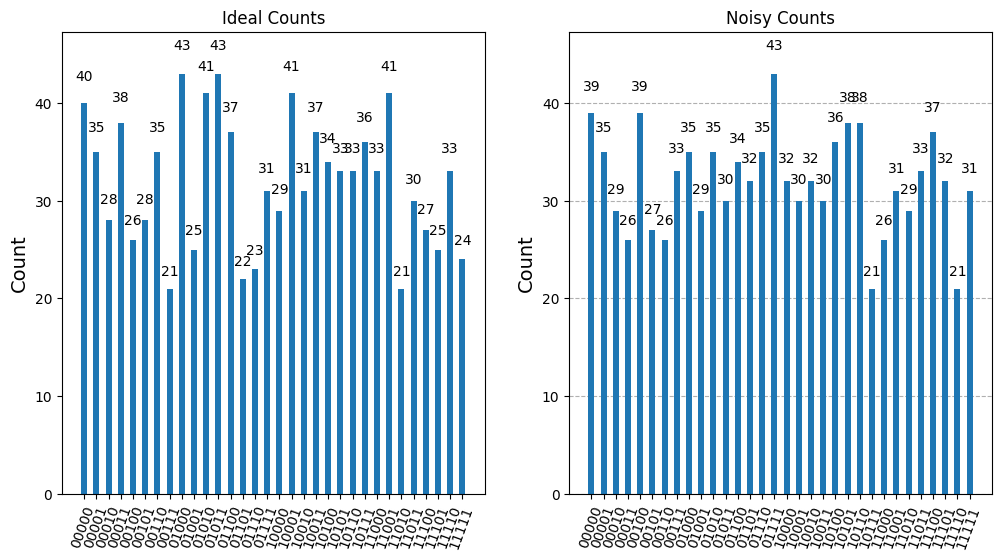

In [4]:
num_qubits = int(input("Enter the number of qubits you'd like in your circuit: "))
qc = QuantumCircuit(num_qubits, num_qubits)
qc.h(range(num_qubits))
qc.measure(range(num_qubits), range(num_qubits))  

ideal_simulator = AerSimulator()

noise_model = noise.NoiseModel.from_backend(backend)
noisy_simulator = AerSimulator(noise_model=noise_model)

ideal_transpiled = transpile(qc, ideal_simulator)
noisy_transpiled = transpile(qc, noisy_simulator)

ideal_result = ideal_simulator.run(ideal_transpiled, shots=1024).result()
ideal_counts = ideal_result.get_counts()

print("Ideal Counts: ", ideal_counts)

noisy_result = noisy_simulator.run(noisy_transpiled, shots=1024).result()
noisy_counts = noisy_result.get_counts()

print("Noisy Counts: ", noisy_counts)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

axs[0].set_title("Ideal Counts")
plot_histogram(ideal_counts, ax=axs[0])

axs[1].set_title("Noisy Counts")
plot_histogram(noisy_counts, ax=axs[1])

plt.show()

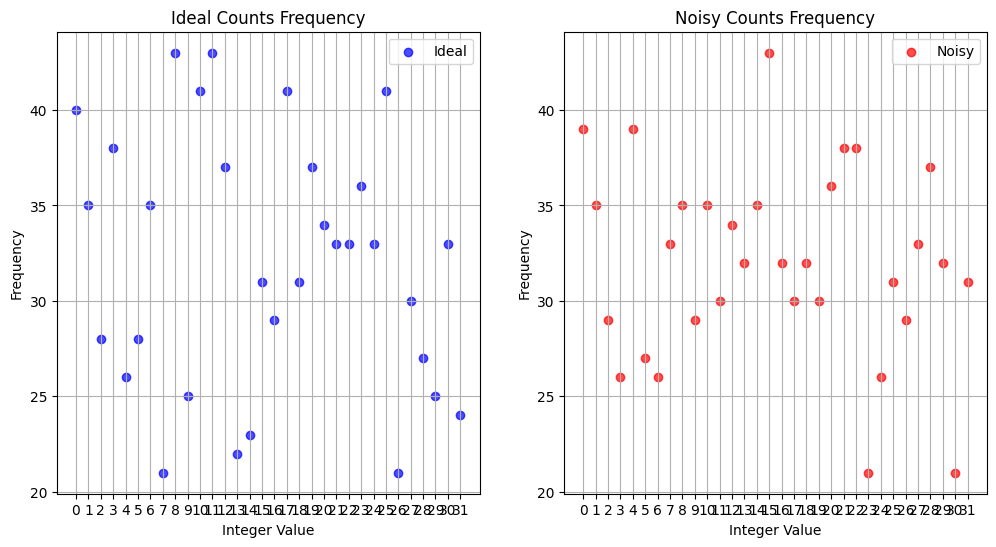

In [5]:
def convert_counts_to_frequencies(counts):
    integers = [int(k, 2) for k in counts.keys()]  # Convert binary string to integer
    frequencies = list(counts.values())            # Get frequencies from counts
    return integers, frequencies

ideal_integers, ideal_frequencies = convert_counts_to_frequencies(ideal_counts)
noisy_integers, noisy_frequencies = convert_counts_to_frequencies(noisy_counts)

plt.figure(figsize=(12, 6))

# Ideal Counts Plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(ideal_integers, ideal_frequencies, color='blue', label='Ideal', alpha=0.7)
plt.title('Ideal Counts Frequency')
plt.xlabel('Integer Value')
plt.ylabel('Frequency')
plt.xticks(ideal_integers)  # Set x-ticks to integer values
plt.grid()
plt.legend()

# Noisy Counts Plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(noisy_integers, noisy_frequencies, color='red', label='Noisy', alpha=0.7)
plt.title('Noisy Counts Frequency')
plt.xlabel('Integer Value')
plt.ylabel('Frequency')
plt.xticks(noisy_integers)  # Set x-ticks to integer values
plt.grid()
plt.legend()

# Display the plots
plt.show()

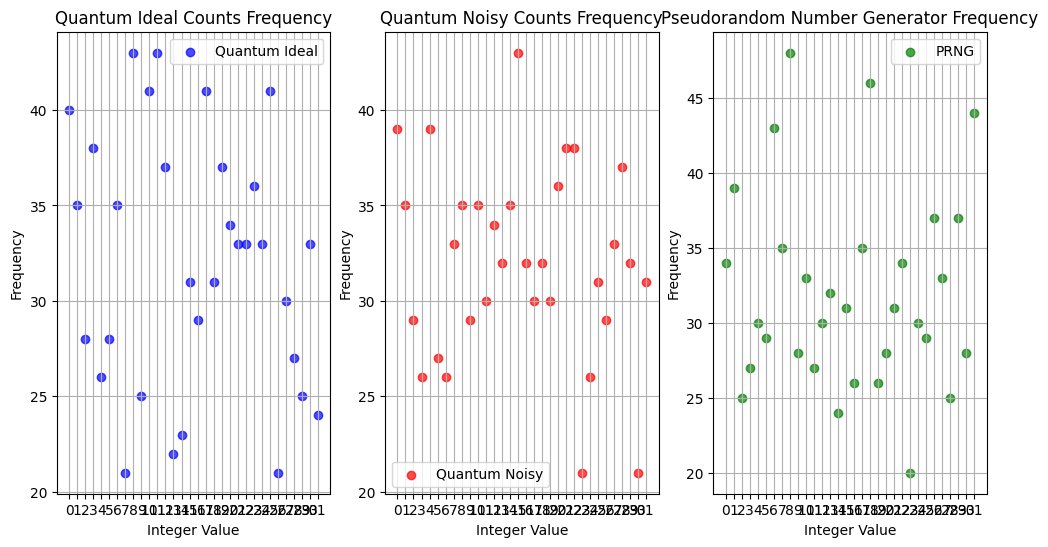

In [6]:
def generate_psuedorandom_counts(size, min_val, max_val):
    random_numbers = np.random.randint(min_val, max_val + 1, size=size)
    counts = np.bincount(random_numbers)  # Count frequencies
    integer_values = np.arange(len(counts))  # Integer values
    frequencies = counts  # Frequencies of these integers
    return integer_values, frequencies

# Set parameters for PRNG
n_samples = 1024  # Number of samples to generate
min_val = 0      # Minimum integer value
max_val = max(ideal_integers + noisy_integers)  # Maximum integer value based on the quantum data

# Generate PRNG counts
prng_integers, prng_frequencies = generate_psuedorandom_counts(n_samples, min_val, max_val)

# Create a figure for comparison
plt.figure(figsize=(12, 6))

# Quantum Ideal Counts Plot
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
plt.scatter(ideal_integers, ideal_frequencies, color='blue', label='Quantum Ideal', alpha=0.7)
plt.title('Quantum Ideal Counts Frequency')
plt.xlabel('Integer Value')
plt.ylabel('Frequency')
plt.xticks(ideal_integers)
plt.grid()
plt.legend()

# Quantum Noisy Counts Plot
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
plt.scatter(noisy_integers, noisy_frequencies, color='red', label='Quantum Noisy', alpha=0.7)
plt.title('Quantum Noisy Counts Frequency')
plt.xlabel('Integer Value')
plt.ylabel('Frequency')
plt.xticks(noisy_integers)
plt.grid()
plt.legend()

# PRNG Counts Plot
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
plt.scatter(prng_integers, prng_frequencies, color='green', label='PRNG', alpha=0.7)
plt.title('Pseudorandom Number Generator Frequency')
plt.xlabel('Integer Value')
plt.ylabel('Frequency')
plt.xticks(prng_integers)
plt.grid()
plt.legend()

plt.show()